In [50]:
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

import open_clip
import cv2
from sentence_transformers import util

import os
from torchvision import transforms as T
import pandas as pd
from Utils.Dataloader import CropDataset
import matplotlib.pyplot as plt
from Utils.TextToImage import unique_char_mapping
from Utils.Filters import applyTransforms

from PIL import Image
import numpy as np
import torch

from SketchKeras.sketch_model import SketchKeras
import Utils.sketchkeras as SK 
import Utils.Predict as P 
from pytorch_fid import fid_score

PATCH_SIZE = 64

image = Image.open("sit_toyosu.png").resize((2048, 2048))
sketch = Image.open("sketch.png").resize((2048, 2048))
ascii_lines = Image.open("output.png").resize((2048, 2048))
bw = Image.open("sit_toyosu.png").convert("L").resize((2048, 2048))
tone = Image.open("converted_sit_toyosu.png").resize((2048, 2048))

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [20]:
def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1

In [21]:
def generateScore(image1, image2):
    # test_img = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    # data_img = cv2.imread(image2, cv2.IMREAD_UNCHANGED)
    img1 = imageEncoder(image1)
    img2 = imageEncoder(image2)
    cos_scores = util.pytorch_cos_sim(img1, img2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score

In [22]:
def extract_patches(image, n, m, filename=None):  
    patches = []
    image = np.array(image)
    height, width = image.shape[:2]
    images_height =0
    images_width = 0

    for y in range(0, height - n + 1, m):
        images_height += 1
        for x in range(0, width - n + 1, m):  
            images_width += 1          
            patch = image[y:y+n, x:x+n]
            patches.append(patch)
    images_width = images_width//images_height
    
    if filename:
        os.makedirs(filename, exist_ok=True)
        for i, patch in enumerate(patches):
            cv2.imwrite(f"{filename}/{filename}_{i}.png", patch)

    return np.array([patch for patch in patches]), images_width, images_height

In [24]:
ascii_imgs, _, _ = extract_patches(ascii_lines, PATCH_SIZE, PATCH_SIZE, filename="ascii_patches")
sketch_imgs, _, _ = extract_patches(sketch, PATCH_SIZE, PATCH_SIZE, filename="sketch_patches")

In [25]:
scores = []

for ascii_img, sketch_img in zip(ascii_imgs, sketch_imgs):
    scores.append(generateScore(ascii_img, sketch_img))

In [26]:
big = Image.open('sit_toyosu.png').convert("L").resize((2048,2048))
tone_imgs, _, _ = extract_patches(tone, PATCH_SIZE, PATCH_SIZE, filename="tone_patches")
normal_imgs, _, _ = extract_patches(big, PATCH_SIZE, PATCH_SIZE, filename="bw_patches")

In [27]:
scores_tone = []
for tone_img, normal_img in zip(tone_imgs, normal_imgs):
    scores_tone.append(generateScore(tone_img, normal_img))

In [28]:
for i, score in enumerate(scores):
    print(f'Image {i} : {(score):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 100.00%
Image 1 : 100.00%
Image 2 : 100.00%
Image 3 : 89.33%
Image 4 : 50.08%
Image 5 : 53.34%
Image 6 : 43.17%
Image 7 : 83.94%
Image 8 : 100.00%
Image 9 : 100.00%
Image 10 : 100.00%
Image 11 : 100.00%
Image 12 : 100.00%
Image 13 : 100.00%
Image 14 : 100.00%
Image 15 : 100.00%
Image 16 : 100.00%
Image 17 : 100.00%
Image 18 : 100.00%
Image 19 : 100.00%
Image 20 : 100.00%
Image 21 : 100.00%
Image 22 : 100.00%
Image 23 : 100.00%
Image 24 : 100.00%
Image 25 : 100.00%
Image 26 : 100.00%
Image 27 : 100.00%
Image 28 : 100.00%
Image 29 : 100.00%
Image 30 : 100.00%
Image 31 : 100.00%
Image 32 : 100.00%
Image 33 : 100.00%
Image 34 : 100.00%
Image 35 : 91.61%
Image 36 : 65.37%
Image 37 : 38.27%
Image 38 : 89.14%
Image 39 : 32.27%
Image 40 : 100.00%
Image 41 : 100.00%
Image 42 : 100.00%
Image 43 : 100.00%
Image 44 : 100.00%
Image 45 : 100.00%
Image 46 : 100.00%
Image 47 : 100.00%
Image 48 : 100.00%
Image 49 : 100.00%
Image 50 : 100.00%
Image 51 : 100.00%
Image 52 : 100.00%
Image 53 : 10

In [29]:
for i, score_tone in enumerate(scores_tone):
    print(f'Image {i} : {(score_tone):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 36.24%
Image 1 : 38.61%
Image 2 : 39.92%
Image 3 : 41.69%
Image 4 : 34.56%
Image 5 : 21.71%
Image 6 : 20.92%
Image 7 : 34.60%
Image 8 : 42.80%
Image 9 : 41.59%
Image 10 : 25.82%
Image 11 : 28.08%
Image 12 : 30.38%
Image 13 : 39.00%
Image 14 : 40.00%
Image 15 : 42.35%
Image 16 : 42.27%
Image 17 : 42.63%
Image 18 : 41.73%
Image 19 : 42.15%
Image 20 : 42.48%
Image 21 : 42.52%
Image 22 : 41.50%
Image 23 : 41.87%
Image 24 : 42.19%
Image 25 : 42.53%
Image 26 : 41.57%
Image 27 : 41.30%
Image 28 : 38.82%
Image 29 : 43.27%
Image 30 : 39.58%
Image 31 : 37.18%
Image 32 : 36.60%
Image 33 : 39.11%
Image 34 : 41.25%
Image 35 : 39.82%
Image 36 : 39.42%
Image 37 : 23.40%
Image 38 : 43.69%
Image 39 : 32.75%
Image 40 : 43.17%
Image 41 : 42.54%
Image 42 : 33.76%
Image 43 : 31.76%
Image 44 : 40.76%
Image 45 : 42.16%
Image 46 : 39.39%
Image 47 : 42.16%
Image 48 : 42.45%
Image 49 : 42.89%
Image 50 : 41.61%
Image 51 : 41.62%
Image 52 : 42.60%
Image 53 : 42.88%
Image 54 : 40.98%
Image 55 : 41.67%
Im

In [42]:
FID_score = fid_score.calculate_fid_given_paths(paths=("sketch_patches/","ascii_patches/"), batch_size=8, dims=2048, device=device)

100%|██████████| 128/128 [00:02<00:00, 52.68it/s]


Image similarity : 38.95%
FID score : 1.2064332608160502


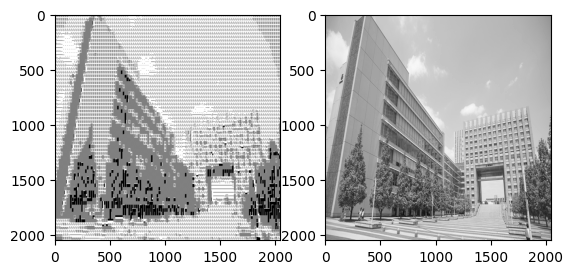

In [43]:
image_mean = np.array(scores_tone).mean()
print(f'Image similarity : {(image_mean):.2f}%')
print(f'FID score : {FID_score}')
plt.subplot(1, 2, 1)
plt.imshow(Image.open("converted_sit_toyosu.png").resize((2048,2048)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(big, cmap='gray')
plt.show()

In [44]:
FID_score_tone = fid_score.calculate_fid_given_paths(paths=("bw_patches/","tone_patches/"), batch_size=8, dims=2048, device=device)

100%|██████████| 128/128 [00:02<00:00, 52.36it/s]


Image similarity : 69.34%
FID score : 3.5790907294383763


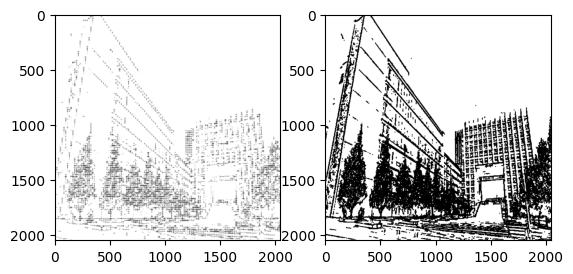

In [45]:
image_mean = np.array(scores).mean()
print(f'Image similarity : {(image_mean):.2f}%')
print(f'FID score : {FID_score_tone}')
plt.subplot(1, 2, 1)
plt.imshow(Image.open("output.png").resize((2048,2048)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(sketch, cmap='gray')
plt.show()